In [5]:
from datetime import datetime, timedelta
import math

import numpy as np
import optuna
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb


import mlflow


In [6]:
# Change this cell if you are not running a local tracking server!

mlflow.set_tracking_uri("http://localhost:8080")


In [7]:
def generate_apple_sales_data_with_promo_adjustment(
    base_demand: int = 1000,
    n_rows: int = 5000,
    competitor_price_effect: float = -50.0,
):
    """
    Generates a synthetic dataset for predicting apple sales demand with multiple
    influencing factors.

    This function creates a pandas DataFrame with features relevant to apple sales.
    The features include date, average_temperature, rainfall, weekend flag, holiday flag,
    promotional flag, price_per_kg, competitor's price, marketing intensity, stock availability,
    and the previous day's demand. The target variable, 'demand', is generated based on a
    combination of these features with some added noise.

    Args:
        base_demand (int, optional): Base demand for apples. Defaults to 1000.
        n_rows (int, optional): Number of rows (days) of data to generate. Defaults to 5000.
        competitor_price_effect (float, optional): Effect of competitor's price being lower
                                                   on our sales. Defaults to -50.
    Returns:
        pd.DataFrame: DataFrame with features and target variable for apple sales prediction.

    Example:
        >>> df = generate_apple_sales_data_with_promo_adjustment(base_demand=1200, n_rows=6000)
        >>> df.head()
    """

    # Set seed for reproducibility
    np.random.seed(9999)

    # Create date range
    dates = [datetime.now() - timedelta(days=i) for i in range(n_rows)]
    dates.reverse()

    # Generate features
    df = pd.DataFrame(
        {
            "date": dates,
            "average_temperature": np.random.uniform(10, 35, n_rows),
            "rainfall": np.random.exponential(5, n_rows),
            "weekend": [(date.weekday() >= 5) * 1 for date in dates],
            "holiday": np.random.choice([0, 1], n_rows, p=[0.97, 0.03]),
            "price_per_kg": np.random.uniform(0.5, 3, n_rows),
            "month": [date.month for date in dates],
        }
    )

    # Introduce inflation over time (years)
    df["inflation_multiplier"] = 1 + (df["date"].dt.year - df["date"].dt.year.min()) * 0.03

    # Incorporate seasonality due to apple harvests
    df["harvest_effect"] = np.sin(2 * np.pi * (df["month"] - 3) / 12) + np.sin(
        2 * np.pi * (df["month"] - 9) / 12
    )

    # Modify the price_per_kg based on harvest effect
    df["price_per_kg"] = df["price_per_kg"] - df["harvest_effect"] * 0.5

    # Adjust promo periods to coincide with periods lagging peak harvest by 1 month
    peak_months = [4, 10]  # months following the peak availability
    df["promo"] = np.where(
        df["month"].isin(peak_months),
        1,
        np.random.choice([0, 1], n_rows, p=[0.85, 0.15]),
    )

    # Generate target variable based on features
    base_price_effect = -df["price_per_kg"] * 50
    seasonality_effect = df["harvest_effect"] * 50
    promo_effect = df["promo"] * 200

    df["demand"] = (
        base_demand
        + base_price_effect
        + seasonality_effect
        + promo_effect
        + df["weekend"] * 300
        + np.random.normal(0, 50, n_rows)
    ) * df[
        "inflation_multiplier"
    ]  # adding random noise

    # Add previous day's demand
    df["previous_days_demand"] = df["demand"].shift(1)
    df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row

    # Introduce competitor pricing
    df["competitor_price_per_kg"] = np.random.uniform(0.5, 3, n_rows)
    df["competitor_price_effect"] = (
        df["competitor_price_per_kg"] < df["price_per_kg"]
    ) * competitor_price_effect

    # Stock availability based on past sales price (3 days lag with logarithmic decay)
    log_decay = -np.log(df["price_per_kg"].shift(3) + 1) + 2
    df["stock_available"] = np.clip(log_decay, 0.7, 1)

    # Marketing intensity based on stock availability
    # Identify where stock is above threshold
    high_stock_indices = df[df["stock_available"] > 0.95].index

    # For each high stock day, increase marketing intensity for the next week
    for idx in high_stock_indices:
        df.loc[idx : min(idx + 7, n_rows - 1), "marketing_intensity"] = np.random.uniform(0.7, 1)

    # If the marketing_intensity column already has values, this will preserve them;
    #  if not, it sets default values
    fill_values = pd.Series(np.random.uniform(0, 0.5, n_rows), index=df.index)
    df["marketing_intensity"].fillna(fill_values, inplace=True)

    # Adjust demand with new factors
    df["demand"] = df["demand"] + df["competitor_price_effect"] + df["marketing_intensity"]

    # Drop temporary columns
    df.drop(
        columns=[
            "inflation_multiplier",
            "harvest_effect",
            "month",
            "competitor_price_effect",
            "stock_available",
        ],
        inplace=True,
    )

    return df


In [8]:
df = generate_apple_sales_data_with_promo_adjustment(base_demand=1_000, n_rows=5000)
df


C:\Users\mateu\AppData\Local\Temp\ipykernel_13160\3984867247.py:86: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row


,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand,competitor_price_per_kg,marketing_intensity
0,2010-03-01 14:34:54.640156,30.584727,1.199291,0,0,1.726258,0,851.375336,851.276659,1.935346,0.098677
1,2010-03-02 14:34:54.640156,15.465069,1.037626,0,0,0.576471,0,906.855943,851.276659,2.344720,0.019318
2,2010-03-03 14:34:54.640156,10.786525,5.656089,0,0,2.513328,0,808.304909,906.836626,0.998803,0.409485
3,2010-03-04 14:34:54.640156,23.648154,12.030937,0,0,1.839225,0,799.833810,857.895424,0.761740,0.872803
4,2010-03-05 14:34:54.640156,13.861391,4.303812,0,0,1.531772,0,983.949061,848.961007,2.123436,0.820779
...,...,...,...,...,...,...,...,...,...,...,...
4995,2023-11-03 14:34:54.636160,21.643051,3.821656,0,0,2.391010,0,1140.210762,1146.064082,1.504432,0.756489
4996,2023-11-04 14:34:54.636160,13.808813,1.080603,1,1,0.898693,0,1702.149505,1189.454273,1.343586,0.742145
4997,2023-11-05 14:34:54.636160,11.698227,1.911000,1,0,2.839860,0,1382.171368,1701.407359,2.771896,0.742145
4998,2023-11-06 14:34:54.636160,18.052081,1.000521,0,0,1.188440,0,1368.369501,1431.429223,2.564075,0.742145


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_correlation_with_demand(df, save_path=None):
    """
    Plots the correlation of each variable in the dataframe with the 'demand' column.

    Args:
    - df (pd.DataFrame): DataFrame containing the data, including a 'demand' column.
    - save_path (str, optional): Path to save the generated plot. If not specified, plot won't be saved.

    Returns:
    - None (Displays the plot on a Jupyter window)
    """

    # Compute correlations between all variables and 'demand'
    correlations = df.corr()["demand"].drop("demand").sort_values()

    # Generate a color palette from red to green
    colors = sns.diverging_palette(10, 130, as_cmap=True)
    color_mapped = correlations.map(colors)

    # Set Seaborn style
    sns.set_style(
        "whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5}
    )  # Light grey background and thicker grid lines

    # Create bar plot
    fig = plt.figure(figsize=(12, 8))
    bars = plt.barh(correlations.index, correlations.values, color=color_mapped)

    # Set labels and title with increased font size
    plt.title("Correlation with Demand", fontsize=18)
    plt.xlabel("Correlation Coefficient", fontsize=16)
    plt.ylabel("Variable", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="x")

    plt.tight_layout()

    

    # Save the plot if save_path is specified
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)

    # prevent matplotlib from displaying the chart every time we call this function
    plt.close(fig)
    return fig


# Test the function
correlation_plot = plot_correlation_with_demand(df, save_path="correlation_plot.png")


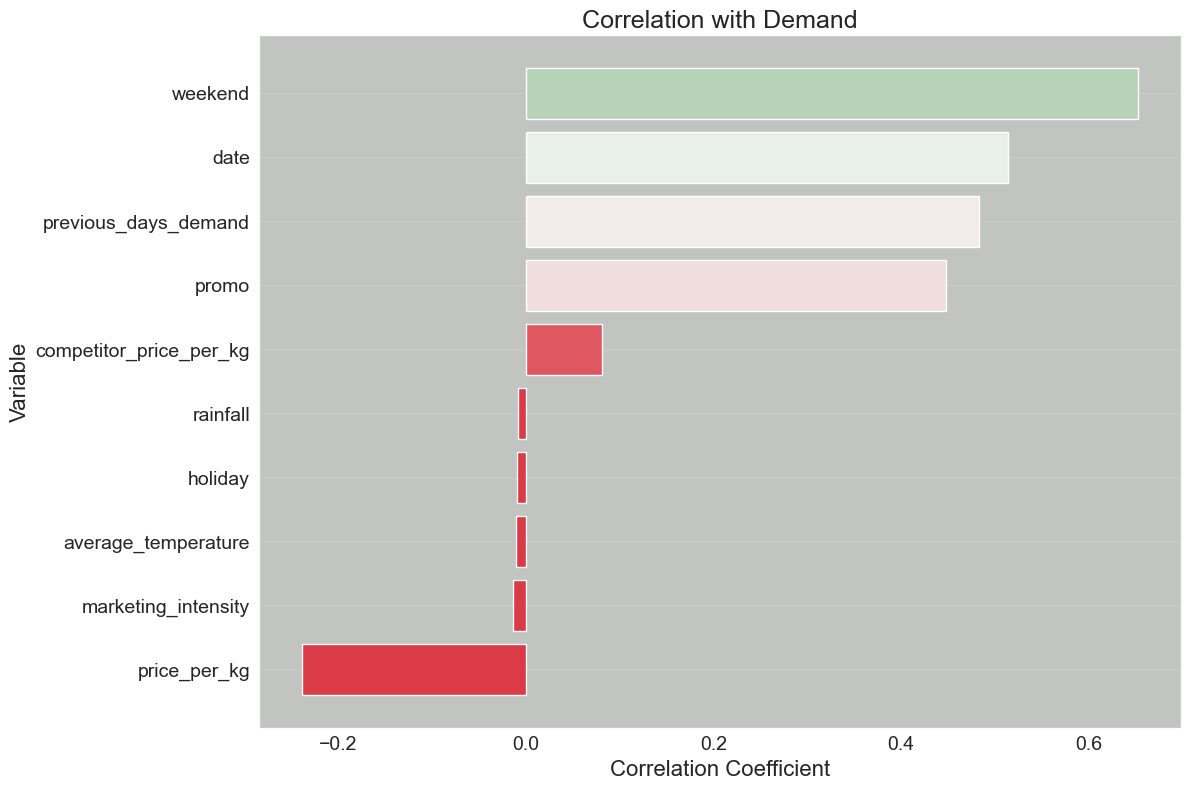

In [14]:
correlation_plot

In [17]:
def plot_residuals(model, dvalid, valid_y, save_path=None):
    """
    Plots the residuals of the model predictions against the true values.

    Args:
    - model: The trained XGBoost model.
    - dvalid (xgb.DMatrix): The validation data in XGBoost DMatrix format.
    - valid_y (pd.Series): The true values for the validation set.
    - save_path (str, optional): Path to save the generated plot. If not specified, plot won't be saved.

    Returns:
    - None (Displays the residuals plot on a Jupyter window)
    """

    # Predict using the model
    preds = model.predict(dvalid)

    # Calculate residuals
    residuals = valid_y - preds

    # Set Seaborn style
    sns.set_style("whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5})

    # Create scatter plot
    fig = plt.figure(figsize=(12, 8))
    plt.scatter(valid_y, residuals, color="blue", alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="-")

    # Set labels, title and other plot properties
    plt.title("Residuals vs True Values", fontsize=18)
    plt.xlabel("True Values", fontsize=16)
    plt.ylabel("Residuals", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="y")

    plt.tight_layout()

    # Save the plot if save_path is specified
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)

    # Show the plot
    plt.close(fig)

    return fig


In [18]:
def plot_feature_importance(model, booster):
    """
    Plots feature importance for an XGBoost model.

    Args:
    - model: A trained XGBoost model

    Returns:
    - fig: The matplotlib figure object
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    importance_type = "weight" if booster == "gblinear" else "gain"
    xgb.plot_importance(
        model,
        importance_type=importance_type,
        ax=ax,
        title=f"Feature Importance based on {importance_type}",
    )
    plt.tight_layout()
    plt.close(fig)

    return fig


In [19]:
def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

    This function checks if an experiment with the given name exists within MLflow.
    If it does, the function returns its ID. If not, it creates a new experiment
    with the provided name and returns its ID.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.

    Returns:
    - str: ID of the existing or newly created MLflow experiment.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)


In [20]:
experiment_id = get_or_create_experiment("Apples Demand")


In [21]:
experiment_id


'107483841051713852'

In [22]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=experiment_id)

# Preprocess the dataset
X = df.drop(columns=["date", "demand"])
y = df["demand"]
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)


In [23]:
# override Optuna's default logging to ERROR only
optuna.logging.set_verbosity(optuna.logging.ERROR)

# define a logging callback that will report on only new challenger parameter configurations if a
# trial has usurped the state of 'best conditions'


def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")


In [24]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Define hyperparameters
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        }

        if params["booster"] == "gbtree" or params["booster"] == "dart":
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            params["grow_policy"] = trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            )

        # Train XGBoost model
        bst = xgb.train(params, dtrain)
        preds = bst.predict(dvalid)
        error = mean_squared_error(valid_y, preds)

        # Log to MLflow
        mlflow.log_params(params)
        mlflow.log_metric("mse", error)
        mlflow.log_metric("rmse", math.sqrt(error))

    return error


In [25]:
run_name = "first_attempt"


In [26]:
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    # Initialize the Optuna study
    study = optuna.create_study(direction="minimize")

    # Execute the hyperparameter optimization trials.
    # Note the addition of the `champion_callback` inclusion to control our logging
    study.optimize(objective, n_trials=500, callbacks=[champion_callback])

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_mse", study.best_value)
    mlflow.log_metric("best_rmse", math.sqrt(study.best_value))

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Apple Demand Project",
            "optimizer_engine": "optuna",
            "model_family": "xgboost",
            "feature_set_version": 1,
        }
    )

    # Log a fit model instance
    model = xgb.train(study.best_params, dtrain)

    # Log the correlation plot
    mlflow.log_figure(figure=correlation_plot, artifact_file="correlation_plot.png")

    # Log the feature importances plot
    importances = plot_feature_importance(model, booster=study.best_params.get("booster"))
    mlflow.log_figure(figure=importances, artifact_file="feature_importances.png")

    # Log the residuals plot
    residuals = plot_residuals(model, dvalid, valid_y)
    mlflow.log_figure(figure=residuals, artifact_file="residuals.png")

    artifact_path = "model"

    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=train_x.iloc[[0]],
        model_format="ubj",
        metadata={"model_data_version": 1},
    )

    # Get the logged model uri so that we can load it from the artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)


Initial trial 0 achieved value: 63655.510492897774
Trial 2 achieved value: 19365.697915684457 with  228.7024% improvement
Trial 4 achieved value: 19220.373907753692 with  0.7561% improvement
Trial 14 achieved value: 18441.388587521775 with  4.2241% improvement
Trial 25 achieved value: 17608.79259797546 with  4.7283% improvement
Trial 32 achieved value: 17023.009542519263 with  3.4411% improvement
Trial 33 achieved value: 15957.763829272899 with  6.6754% improvement
Trial 40 achieved value: 15849.595946596883 with  0.6825% improvement
Trial 51 achieved value: 15712.953203218422 with  0.8696% improvement
Trial 53 achieved value: 15637.590136564726 with  0.4819% improvement
Trial 67 achieved value: 15476.139711647325 with  1.0432% improvement
Trial 112 achieved value: 15341.111187486002 with  0.8802% improvement
Trial 199 achieved value: 15236.092157431245 with  0.6893% improvement
Trial 376 achieved value: 15222.391172354155 with  0.0900% improvement


C:\Users\mateu\github\mlflow_tutorial\geitting_started\mlflow_venv\Lib\site-packages\mlflow\models\signature.py:351: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  input_schema = _infer_schema(input_example)
